# M5 Timeseries Clusterization with k-Shape

This notebook is based on amazing [Tslearn, A Machine Learning Toolkit for Time Series Data](https://tslearn.readthedocs.io/en/stable/quickstart.html)
and uses [this](https://www.kaggle.com/sibmike/m5-out-of-stock-feature-640x-faster) notebook to find M5 out-of-stocks. It has just two goals:
* show some **basic preprocessing**
* show an **easy way to clusterize timeseries with k-Shape**

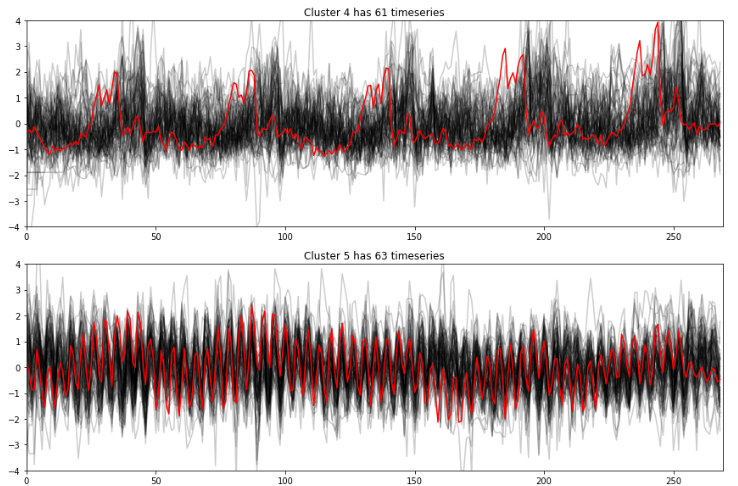

## The plan:
### 0. Load datasets

### 1. Preprocessing:
* Cap 3 sigma outliers and then fill in stockouts with the mean sales in preceding week.
* Aggregate to weekly-product_id
* Log scale timeseries to further lower the impact of outliers
* Standardscaler to bring all time series to one scale

### 2. k-Shape Clusterization
* Find clusters for weeks 0-270
* Find clusters for weeks 0-150
* Find clusters for weeks 150-270

We will not try to use the clusters for training, but you can try it out on your own.

## [Shortcut to cluster pictures; skipping data processing](https://www.kaggle.com/sibmike/m5-eazzy-time-series-clusterization-with-k-shape#2.-Easy-time-series-clustering-with-k-Shape)

In [ ]:
!pip install tslearn

In [ ]:
import numpy as np
import pandas as pd

from scipy import stats

from sklearn.preprocessing import scale
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

from tqdm.notebook import tqdm

#Special tools for timeseries:
from tslearn.clustering import KShape
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

import gc
import matplotlib.pylab as plt
%matplotlib inline

In [ ]:
# Memory reduction helper function:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns: #columns
        col_type = df[col].dtypes
        if col_type in numerics: #numerics
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# 0. Load Datasets
All three datasets needed because we need to calculate sales in USD.

In [ ]:
# DEFAULT datasets
data_pass = '/kaggle/input/m5-forecasting-accuracy/'

# Sales quantities:

# Calendar to get week number to join sell prices:
calendar = pd.read_csv(data_pass+'calendar.csv')
calendar.d = calendar.d.str.extract('(\d+)').astype(np.int16)
calendar = reduce_mem_usage(calendar)

### var explanation:
For complete explanation of how we got **gap_e** & **gap_days** variables take a look at ["M5 - 'out_of_stock' feature 640x faster"](https://www.kaggle.com/sibmike/m5-out-of-stock-feature-640x-faster). Here is brief explanation of variables:
* **gap_e** - how many years needed to observe a gap of length 'gap_days' <-- We only use this one
* **gap_days** - int, number of days in sequence of consecutive zeroes

In [ ]:
# GAPS datasets
gap_columns = ['id', 'item_id','dept_id', 'd', 'sales', 'gap_e']

# Load grid with identified stockouts:
file_pass = '../input/m5-out-of-stock-feature-640x-faster/grid_part_1_gaps.pkl'
grid_df = reduce_mem_usage(pd.read_pickle(file_pass)[gap_columns])

# Add week of year:
grid_df = pd.merge(
    grid_df, 
    calendar[['wm_yr_wk','event_name_1','d']], 
    how = 'left', 
    left_on = ['d'], 
    right_on = ['d']
)

grid_df.head()
del calendar

In [ ]:
# To select timeseries features useful for clusterization we will need to split them in two classes.
# We will use the 'dept_id' to do the splits:

targets = list(grid_df.dept_id.unique())
grid_df.drop(columns=['dept_id'], inplace=True)

In [ ]:
# I use 100 years as threshold for a stockout. If you feel it is too much, lower it.
years_threshold = 100
grid_df.loc[:,'stockout'] = (grid_df.gap_e >= years_threshold)*1

# 1. Preprocessing:
### Cap 3 sigma outliers:
There should be a more elegant way to do this. But this is the fastest I could think of.

In [ ]:
# Find outliers based on z score:
## Filter out values more than 0 as otherwise all sales might be flagged as outliers:
mask = grid_df.sales > 0

## Group by 'id' as sales values have diffrenet mean from store to store: 
df_grouped = grid_df[mask].groupby(['id'])

## Find indices of all outliers:
outlier_idx = []
for group_name, g in tqdm(df_grouped):
    outlier_idx += list(g[stats.zscore(g.sales) > 3].index) 
    
## Create separate column with outliers: zeroes by default & sales values for outliers values.
grid_df.loc[:,'sale_outlier'] = 0
grid_df.loc[outlier_idx,'sale_outlier'] = grid_df.loc[outlier_idx,'sales']

In [ ]:
# Cap sales outliers with maximum non outlier value:
grid_df['sales_clean'] = grid_df['sales']
nan_idx = grid_df[~grid_df.sales.isna()].index
grid_df.loc[outlier_idx,'sales_clean'] = np.nan

grid_df.loc[nan_idx,'sales_clean'] = grid_df.loc[nan_idx,'sales_clean'].fillna(grid_df.groupby('id',sort=False)['sales_clean'].transform('max'))

### ... and then fill in stockouts with last seen sales.

In [ ]:
mask = grid_df.stockout>0
grid_df.loc[mask,'sales_clean'] = np.nan

# Group by id:
df_grouped = grid_df.groupby("id",sort=False)["sales_clean"]

# Generate rolling mean to fill in stockouts:
lag = 1
w = 7
col_name = f"rolling_w{str(w)}_l{str(lag)}_mean"
grid_df[col_name] = df_grouped.transform(lambda x: x.shift(lag).rolling(w, min_periods=w).mean()).astype(np.float32)
grid_df[col_name] = grid_df[col_name].fillna(method='ffill')

# Fill in stockouts: 
grid_df.loc[mask, 'sales_clean'] = grid_df.loc[mask, col_name]

### Weekly sales & Scaling

In [ ]:
# Create week-porduct_id aggregations:
week_df = grid_df[['item_id','wm_yr_wk','sales_clean']].groupby(['item_id','wm_yr_wk'], sort=False).mean().fillna(0).astype(np.float32)
week_df.reset_index(inplace=True)

In [ ]:
# Note we add 1 so that zeroes map to zeroes and small values map to small values.
week_df.loc[:, 'sales_clean'] = np.log(week_df.sales_clean+1)

In [ ]:
# Please, note that this is implementation is one-way there is no way to go back to unscaled version.
# However, we only use the target for clusterization not prediction here.
week_df['sales_clean'] = week_df.groupby('item_id').sales_clean.transform(lambda x: scale(x.astype(float)))
week_df.loc[:,'week_number'] = week_df.wm_yr_wk.map(dict(zip(list(week_df.wm_yr_wk),list(range(len(week_df.wm_yr_wk.unique()))))))
week_df.drop(columns=['wm_yr_wk'], inplace=True)
week_df.head()

In [ ]:
del grid_df

# 2. Easy time series clustering with k-Shape

Here is the original paper [k-Shape: Efficient and Accurate Clustering of Time Series by John Paparrizos & Luis Gravano](https://dl.acm.org/doi/pdf/10.1145/2723372.2737793), which is another proof of why we need to know kick ass math.

### The whole history
First we use the whole history and see if k-Shape makes any sense. If you wonder what the red line means - it is the pattern shared by timeseries but which might be shifted left or right for each one of them.

In [ ]:
nc = 20
start_week = 0
end_week = 270

seed = 0
np.random.seed(seed)
week_mask = (week_df.week_number>start_week) & (week_df.week_number <end_week)
X_train = week_df.loc[week_mask,['item_id','sales_clean','week_number']].pivot(columns='item_id', index='week_number').T.values

# For this method to operate properly, prior scaling is required
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)
sz = X_train.shape[1]

# kShape clustering
ks = KShape(n_clusters=nc, verbose=True, random_state=seed)
y_pred = ks.fit_predict(X_train)

plt.figure(figsize=(12,nc*4))
for yi in range(nc):
    plt.subplot(nc, 1, 1 + yi)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(ks.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.title(f"Cluster {str(yi + 1)} has {str(X_train[y_pred == yi].shape[0])} timeseries") 

plt.tight_layout()
plt.show()

### Now lets split history in two parts:
* First, try to clusterize on the first few years, there we will cluster products based on effective start of sales
* Then clusterize on the last two years, there we will split clusters by yearly patterns

In [ ]:
# Clusters in first 3 years:

nc = 12
start_week = 0
end_week = 160

week_mask = (week_df.week_number>start_week) & (week_df.week_number <end_week)
X_train = week_df.loc[week_mask,['item_id','sales_clean','week_number']].pivot(columns='item_id', index='week_number').T.values

# For this method to operate properly, prior scaling is required
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)
sz = X_train.shape[1]

# kShape clustering
ks = KShape(n_clusters=nc, verbose=True, random_state=seed)
y_pred = ks.fit_predict(X_train)

plt.figure(figsize=(12,nc*4))
for yi in range(nc):
    plt.subplot(nc, 1, 1 + yi)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(ks.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.title(f"Cluster {str(yi + 1)} has {str(X_train[y_pred == yi].shape[0])} timeseries") 

plt.tight_layout()
plt.show()

### The last two years
Probably the most exciting part as it focus on patterns during last two years and disregards when time series started.

In [ ]:
# Clusters in last two years:

nc = 12
start_week = 162
end_week = 270

week_mask = (week_df.week_number>start_week) & (week_df.week_number < end_week)
X_train = week_df.loc[week_mask,['item_id','sales_clean','week_number']].pivot(columns='item_id', index='week_number').T.values

# For this method to operate properly, prior scaling is required
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)
sz = X_train.shape[1]

# kShape clustering
ks = KShape(n_clusters=nc, verbose=True, random_state=seed)
y_pred = ks.fit_predict(X_train)

plt.figure(figsize=(12,nc*4))
for yi in range(nc):
    plt.subplot(nc, 1, 1 + yi)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(ks.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.title(f"Cluster {str(yi + 1)} has {str(X_train[y_pred == yi].shape[0])} timeseries") 

plt.tight_layout()
plt.show()

### That's All Folks!

Now you can see that k-Shape works amazingly well. It is also hard to beat with other clusterization mathods.
However, to get a boost in LB it might take some furhter feature engineering.